In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

Starting path:/home/gregorymar577/VESUVIUS_Challenge/jupyter notebooks
Current path:/home/gregorymar577/VESUVIUS_Challenge


In [2]:
import torch
import monai
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn

import torch.nn as nn
from functools import partial
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from lit_models.scratch_models import FPNDecoder
import gc
from Models.PreBackbone_3d_Zdim import PreBackbone_3D_ZDIM
from Models.PreBackbone_3D import PreBackbone_3D

2023-05-29 23:23:27,055 - Created a temporary directory at /tmp/tmpgv94ekud
2023-05-29 23:23:27,057 - Writing /tmp/tmpgv94ekud/_remote_module_non_scriptable.py


In [3]:
CHECKPOINT = 'logs/24_bnorm_BMasked_Att3D_SmpU_mitb3_bce3_05tver70/last.ckpt'
SAMPLE_SUBMISSION = 'kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv'


PATCH_SIZE = 256
Z_DIM = 24
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
class Model_3dAtt_w_Segformer(nn.Module):
    def __init__(self ):
        
        super().__init__()
        
        self.model_3d =PreBackbone_3D_ZDIM(out_channels = 3,
                                           z_dim= Z_DIM, 
                                           emdedding_dims=[8],
                                           filter_sizes=[32, 64, 128]).to(DEVICE) 
        
       
        self.model_2d = smp.Unet(encoder_name='mit_b3',
                                 encoder_depth=5,
                                 encoder_weights='imagenet', 
                                 decoder_use_batchnorm=True, 
                                 decoder_channels=(512, 256, 128, 64, 32,),
                                 decoder_attention_type=None,
                                 in_channels=3,
                                 classes=1, activation=None, aux_params=None).to(DEVICE) 

       

    def forward(self, x):
      
        outs_3d = self.model_3d(x)
        logits = self.model_2d(outs_3d)
        
       
       
            
        
        return logits












In [5]:

class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.5
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'test' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    test_fragment_ids = ['a','b']
    
    

    
    
    batch_size = 4
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = Model_3dAtt_w_Segformer().to(DEVICE) 
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 192// batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 1e-7
    t_max = 80
    max_epochs = 120
    weight_decay =  0.0001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

In [6]:
lit_model = Lit_Model(cfg=CFG)

lit_model = lit_model.load_from_checkpoint(CHECKPOINT, cfg=CFG,).to(CFG.device)

lit_model.eval()

Lit_Model(
  (metrics): ModuleDict(
    (train_metrics): MetricCollection(
      (dice): Dice(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (dice): Dice(),
      prefix=val_
    )
  )
  (model): Model_3dAtt_w_Segformer(
    (model_3d): PreBackbone_3D_ZDIM(
      (embed_layer): Embed(
        (conv_3d): Conv3d(1, 8, kernel_size=(3, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
        (conv_3d_embed): Conv3d(8, 1, kernel_size=(1, 4, 4), stride=(1, 4, 4), padding=(0, 1, 1))
        (norm): LayerNorm2d((8,), eps=1e-05, elementwise_affine=True)
        (norm_embed): LayerNorm2d((1,), eps=1e-05, elementwise_affine=True)
      )
      (attention): EfficientMultiHeadAttention(
        (reducer): Sequential(
          (0): Conv2d(12, 12, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm_att((12,), eps=1e-05, elementwise_affine=True)
        )
        (att): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

mask_count_min: 0.0


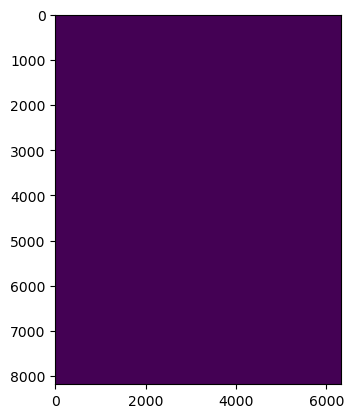

/tmp/ipykernel_24701/1845676345.py:236: RuntimeWarning: divide by zero encountered in true_divide
  score = beta * beta / (1 + beta * beta) * 1 / recall + 1 / (1 + beta * beta) * 1 / precision
/tmp/ipykernel_24701/1845676345.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  score = beta * beta / (1 + beta * beta) * 1 / recall + 1 / (1 + beta * beta) * 1 / precision


bce=33.22940
th   prec   recall   fpr   dice   score
---------------------------------------
0.1, 0.153, 1.000, 0.634,  0.266,  0.185
0.2, 0.185, 1.000, 0.507,  0.312,  0.221
0.3, 0.250, 0.086, 0.029,  0.128,  0.181
0.4, 0.028, 0.000, 0.000,  0.000,  0.000
0.5, 0.000, 0.000, 0.000,  0.000,  0.000
0.6, 0.000, 0.000, 0.000,  0.000,  0.000
0.7, 0.000, 0.000, 0.000,  0.000,  0.000
0.8, 0.000, 0.000, 0.000,  0.000,  0.000
0.9, 0.000, 0.000, 0.000,  0.000,  0.000


In [7]:
def TTA(x:torch.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    if 1:
        shape=x.shape
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=torch.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=torch.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x
def make_val_dataset(fragment_id):
    test_images = read_image_val(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.patch_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.patch_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.patch_size
            x2 = x1 + CFG.patch_size
            if np.all(test_images[y1:y2, x1:x2]==0):
                continue
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=CFG.on_gpu, drop_last=False)
    
    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(
        [
        A.Resize(CFG.patch_size, CFG.patch_size),
        A.Normalize(
            mean=[0] * CFG.z_dim,
            std=[1] * CFG.z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
    )

def read_image_val(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.patch_size - image.shape[0] % CFG.patch_size)
        pad1 = (CFG.patch_size - image.shape[1] % CFG.patch_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image
    
    
    
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


THRESHOLD =0.6
results = []
saved_result_val = []
for fragment_id in [1]:
    
    test_loader, xyxys = make_val_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"train/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape)#.to(CFG.device)
    mask_count = torch.zeros(binary_mask.shape)#.to(CFG.device)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        #images = images.unsqueeze(1)

        
        with torch.no_grad():
            #y_preds = lit_model(images)
            #y_preds = torch.sigmoid(y_preds)
            #y_preds = y_preds.sigmoid().squeeze()
            #y_preds = y_preds.numpy()
            #print(type(y_preds))
            y_preds = TTA(images,lit_model)

        y_preds = y_preds.to('cpu')
        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size))#.to(DEVICE)
    
    #plt.imshow(mask_count.to('cpu'))
   # plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    #mask_pred /= mask_count
    mask_pred /=(mask_count +1e-5)
    
    #fig, axes = plt.subplots(1, 4, figsize=(15, 8))
   
    
    
    mask_pred = mask_pred.to('cpu').numpy()
    
    # Denoising
    
    #mask_pred=xp.array(mask_pred)
    #mask_pred=denoise_image(mask_pred, iter_num=250)
    #mask_pred=mask_pred.get()
    
     #axes[2].imshow(mask_pred)
    
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    #mask_pred = mask_pred.to('cpu').numpy()
    saved_result_val.append(mask_pred)
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    #axes[3].imshow(mask_pred)
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    
    results.append( inklabels_rle)
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
def metric_to_text(ink, label):
    text = []

    p = ink.reshape(-1)
    t = label.reshape(-1)
    pos = np.log(np.clip(p,1e-7,1))
    neg = np.log(np.clip(1-p,1e-7,1))
    bce = -(t*pos +(1-t)*neg).mean()
    text.append(f'bce={bce:0.5f}')


    #print(f'{threshold:0.1f}, {precision:0.3f}, {recall:0.3f}, {fpr:0.3f},  {dice:0.3f},  {score:0.3f}')
    text.append('th   prec   recall   fpr   dice   score')
    text.append('---------------------------------------')
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        p = ink.reshape(-1)
        t = label.reshape(-1)
        p = (p > threshold).astype(np.float32)
        t = (t > 0.5).astype(np.float32)

        tp = p * t
        precision = tp.sum() / (p.sum() + 0.0001)
        recall = tp.sum() / t.sum()

        fp = p * (1 - t)
        fpr = fp.sum() / (1 - t).sum()

        beta = 0.5
        #  0.2*1/recall + 0.8*1/prec
        score = beta * beta / (1 + beta * beta) * 1 / recall + 1 / (1 + beta * beta) * 1 / precision
        score = 1 / score

        dice = 2 * tp.sum() / (p.sum() + t.sum())

        # print(fold, threshold, precision, recall, fpr,  score)
        text.append( f'{threshold:0.1f}, {precision:0.3f}, {recall:0.3f}, {fpr:0.3f},  {dice:0.3f},  {score:0.3f}')
    text = '\n'.join(text)
    return text


label =  cv2.imread(COMPETITION_DATA_DIR_str + f"train/{fragment_id}/inklabels.png", 0)
text = metric_to_text(saved_result_val[0], label)
print(text)

In [8]:
def TTA(x:torch.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    if 1:
        shape=x.shape
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=torch.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=torch.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x

def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.patch_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.patch_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.patch_size
            x2 = x1 + CFG.patch_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=CFG.on_gpu, drop_last=False)
    
    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(
        [
        A.Resize(CFG.patch_size, CFG.patch_size),
        A.Normalize(
            mean=[0] * CFG.z_dim,
            std=[1] * CFG.z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
    )

def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.patch_size - image.shape[0] % CFG.patch_size)
        pad1 = (CFG.patch_size - image.shape[1] % CFG.patch_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image
    
    
    
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
THRESHOLD =0.3
results = []
saved_results = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(CFG.device)
    mask_count = torch.zeros(binary_mask.shape).to(CFG.device)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            #y_preds = lit_model(images)
            #y_preds = torch.sigmoid(y_preds)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))
            y_preds = TTA(images,lit_model)

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    saved_results.append(mask_pred)
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    
    results.append( inklabels_rle)
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
THRESHOLD = 0.5
for image in saved_results:
    mask_pred = image
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    plt.imshow(mask_pred)
    plt.show()









    gc.collect()
    torch.cuda.empty_cache()